# Evaluation of CCLM testruns with ERA5 for individual point data

In [2]:
import valenspy as vp
import xarray as xr
from pathlib import Path
import cdo 
from yaml import safe_load
import os
import matplotlib.pyplot as plt
 
# define machine name - used for paths of (observational) datasets
machine = 'hortense'

model = "CCLM"

# postprocessing base directory 
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

src_path = Path("../src/valenspy")


In [3]:
# reference dataset to compare to


# secondary list of variables to compare
# cloud characteristics (integrated cloud water, ice, graupel, snow and rain) (NOT YET IN CORDEX_VARIABLES list)
# ERA5-land: surface fluxes: latent heat, sensible heat

# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

### 1. Load preprocessed CCLM data

In [4]:
# directory with experiments

# experiments = ["EUR11_CO_TA_GC_TSO",
#                "EUR11_CO_TT_GC_TSO", 
#                "EUR11_CO_TT_EC_TSO", 
#                "EUR11_NU_TE_GC_TSO", 
#                "EUR11_NU_TT_GC_TSO", 
#                "EUR11_NU_TT_EC_TSO"]

experiments = ["BE28_Nukleus_3h",
               "BE28_Ruben",
               "BE28_Nick"]               

# to be added  "EUR11_CO_TE_GC_TSO"

experiment = experiments[0]

proc_dir = postproc_base_dir + experiment

with open(src_path / "ancilliary_data" / Path(model+"_lookup.yml")) as file:
    mod_LOOKUP = safe_load(file)


In [5]:
# do selection of individual points (do this in separate notebook.)
# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']


months_to_analyse = [5,6,7,8]

unit_conversion = False


### plotting function

In [ ]:
# ------------------------------
# 1. Load reference data


def plot_point_timeseries(variable: str, ref_dataset: str, experiments: list, point_coord: tuple, point_id:str,  months_to_analyse: list, unit_conversion=False, ax=False): 
        
    # start up input manager
    manager = vp.InputManager(machine=machine)

    # use input manager to load data, defined on settings above
    #ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
    ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region=region)
    ds_obs = ds_obs.resample(time='1D').mean() 

    # quick and dirty fix to account for correct units for cumulative variables in ERA5 and ERA5 land - to be properly solved in the inputmanager
    if unit_conversion: 
        print('did unit conversion')
        ds_obs[variable] = ds_obs[variable]/(86400)

    # select point 
    ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # generate path of CCLM output

    # dictorionary to save data arrays of experiments
    d_da_mod_point = {}

    for experiment in experiments: 
        # get CCLM variable corresponding to the requested variable using its look-up table
        mod_var = mod_LOOKUP[variable]['raw_name']

        # define the path
        directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/daily/')

        # open the CCLM file for the corresponding variable
        mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

        if not mod_files:  # empty list - move to next element in loop
            print(f"{variable} not available for {experiment}")
            continue
            
        ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

        coord_points_rotated = geo_to_rot(point_coord, ds_mod)
        ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

        da_mod_point = ds_mod_point[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        d_da_mod_point[experiment] = da_mod_point

    # do plotting
    # when no ax element is passed, create the figure within the function
    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in d_da_mod_point: 
        d_da_mod_point[experiment].plot(ax=ax, label = experiment, alpha=0.5)

    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    ax.set_title(da_obs_point.attrs['long_name'], loc='left')

    # only add legend if stand-alone figure
    if not ax: 
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

        
    return ax



def plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=False):

    "Wrapper function to combine 4 point timeseries plot into one figure, with nice layout (legend and title)"
    fig, axes = plt.subplots(2,2,figsize = (16,6))
    axes = axes.flatten()

    for i,point_id in enumerate(d_point_coords): 
        ax = axes[i]
        ax = plot_point_timeseries(variable, ref_dataset, experiments, d_point_coords[point_id], point_id,  months_to_analyse, unit_conversion, ax=ax)

        if i == 1: 
            ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()


### 2m temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1

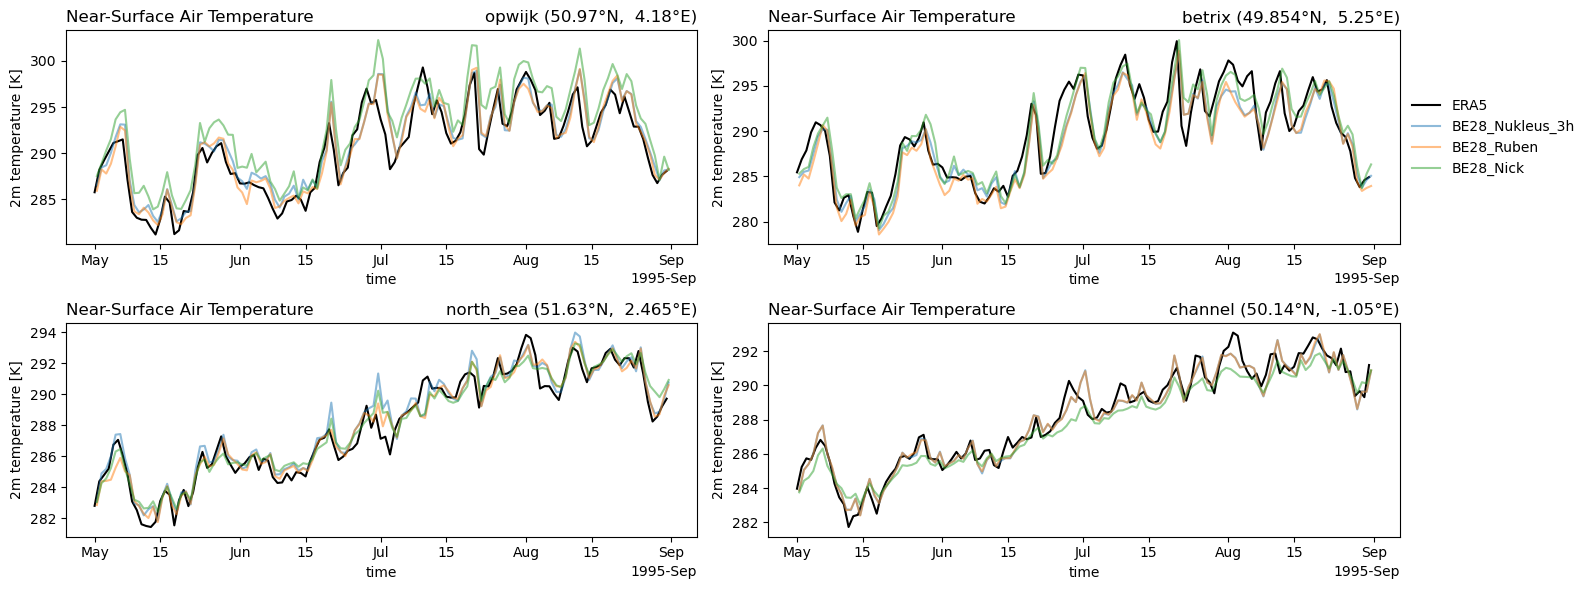

In [ ]:
# variables of interest
variable = "tas"
region = 'europe'
ref_dataset = 'ERA5'
months_to_analyse = [5,6,7,8]

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

In [16]:
# start up input manager
manager = vp.InputManager(machine=machine)

# use input manager to load data, defined on settings above
#ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region=region)
ds_obs = ds_obs.resample(time='1D').mean() 

# quick and dirty fix to account for correct units for cumulative variables in ERA5 and ERA5 land - to be properly solved in the inputmanager
if unit_conversion: 
    print('did unit conversion')
    ds_obs[variable] = ds_obs[variable]/(86400)

# select point 
ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


# generate path of CCLM output

# dictorionary to save data arrays of experiments
d_da_mod_point = {}

for experiment in experiments: 
    # get CCLM variable corresponding to the requested variable using its look-up table
    mod_var = mod_LOOKUP[variable]['raw_name']

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

    # open the CCLM file for the corresponding variable
    mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    if not mod_files:  # empty list - move to next element in loop
        print(f"{variable} not available for {experiment}")
        continue
        
    ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

    coord_points_rotated = geo_to_rot(point_coord, ds_mod)
    ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

    da_mod_point = ds_mod_point[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

    d_da_mod_point[experiment] = da_mod_point



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
tas not available for BE28_Nukleus_3h
tas not available for BE28_Ruben
tas not available for BE28_Nick


### Cloudiness

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clt']
The following attributes are missing or incorrect for the variable clt:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clt']
The following attributes are missing or incorr

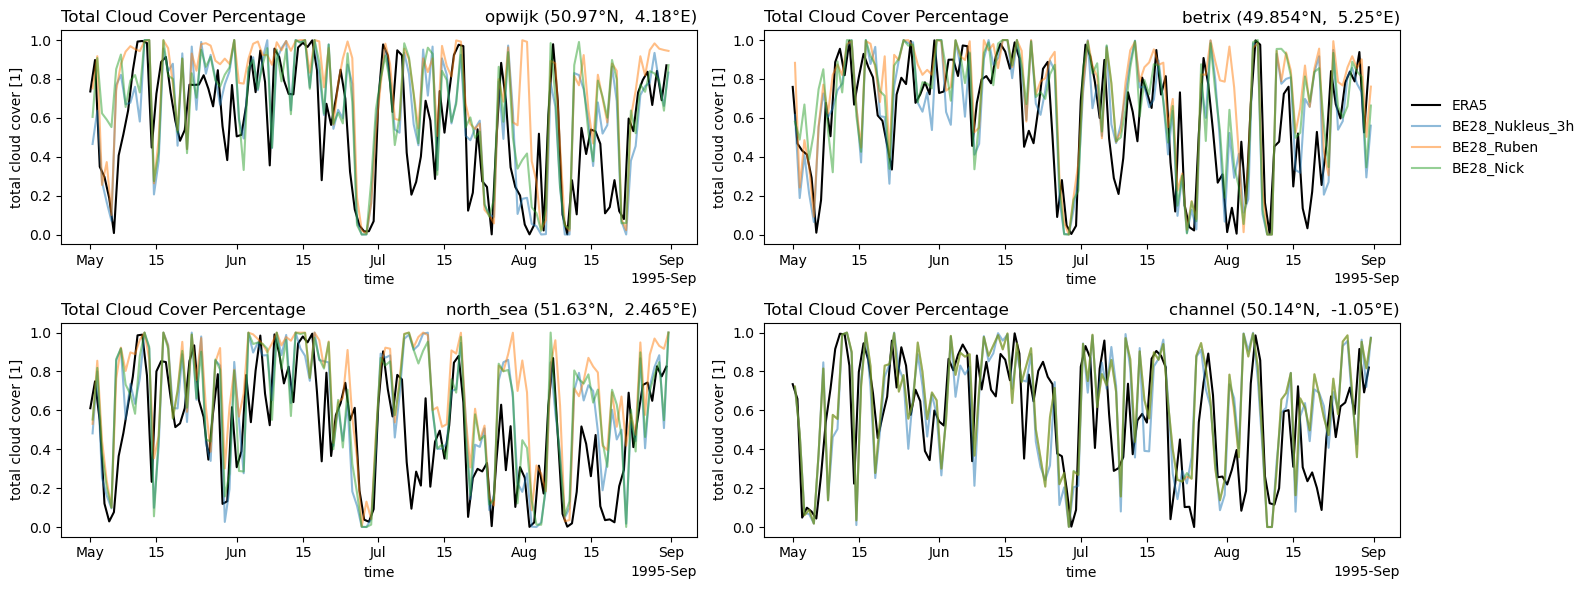

In [17]:
# variables of interest
variable = "clt"
region = 'belgium'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

### Total cloudiness in july

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clt']
The following attributes are missing or incorrect for the variable clt:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clt']
The following attributes are missing or incorrect for the variable clt:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clt']
The following attributes are missing or incorr

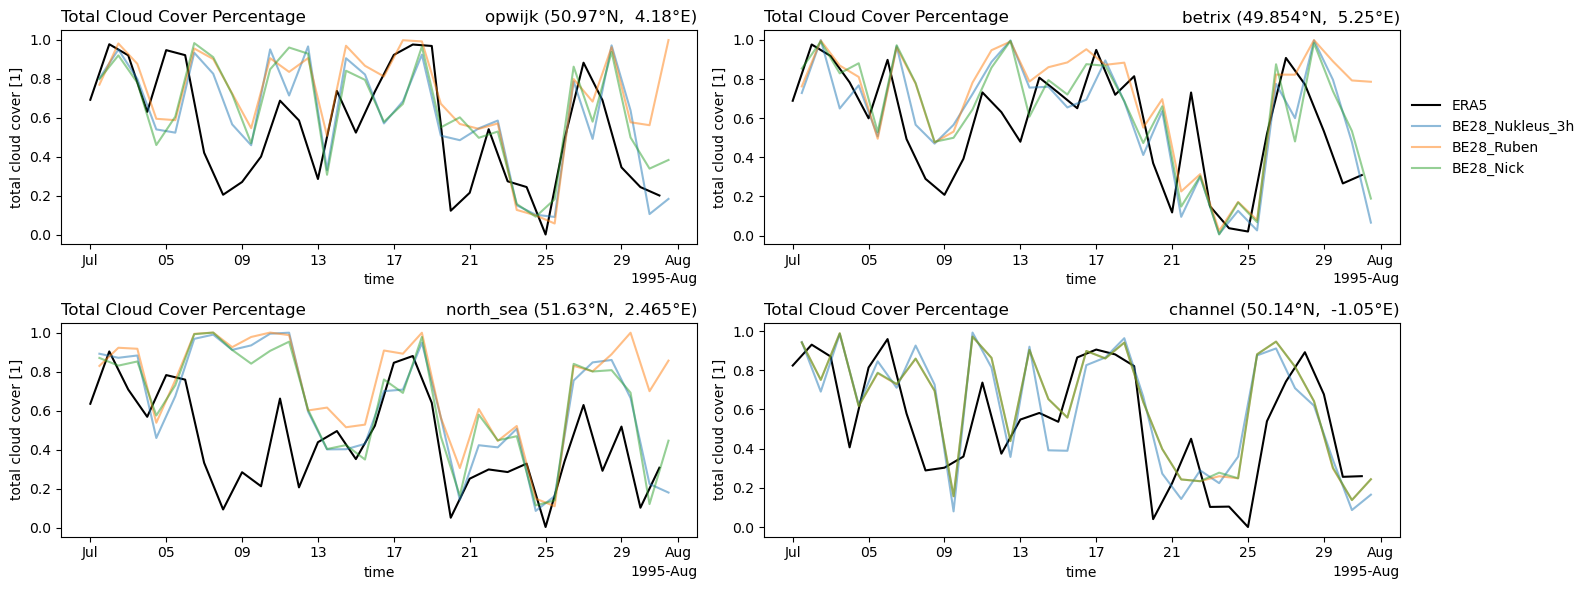

In [18]:
# variables of interest

variable = "clt"
region = 'belgium'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[7])

### Low clouds

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['cll']
The following attributes are missing or incorrect for the variable cll:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['cll']
The following attributes are missing or incorrect for the variable cll:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['cll']
The following attributes are missing or incorrect for the 

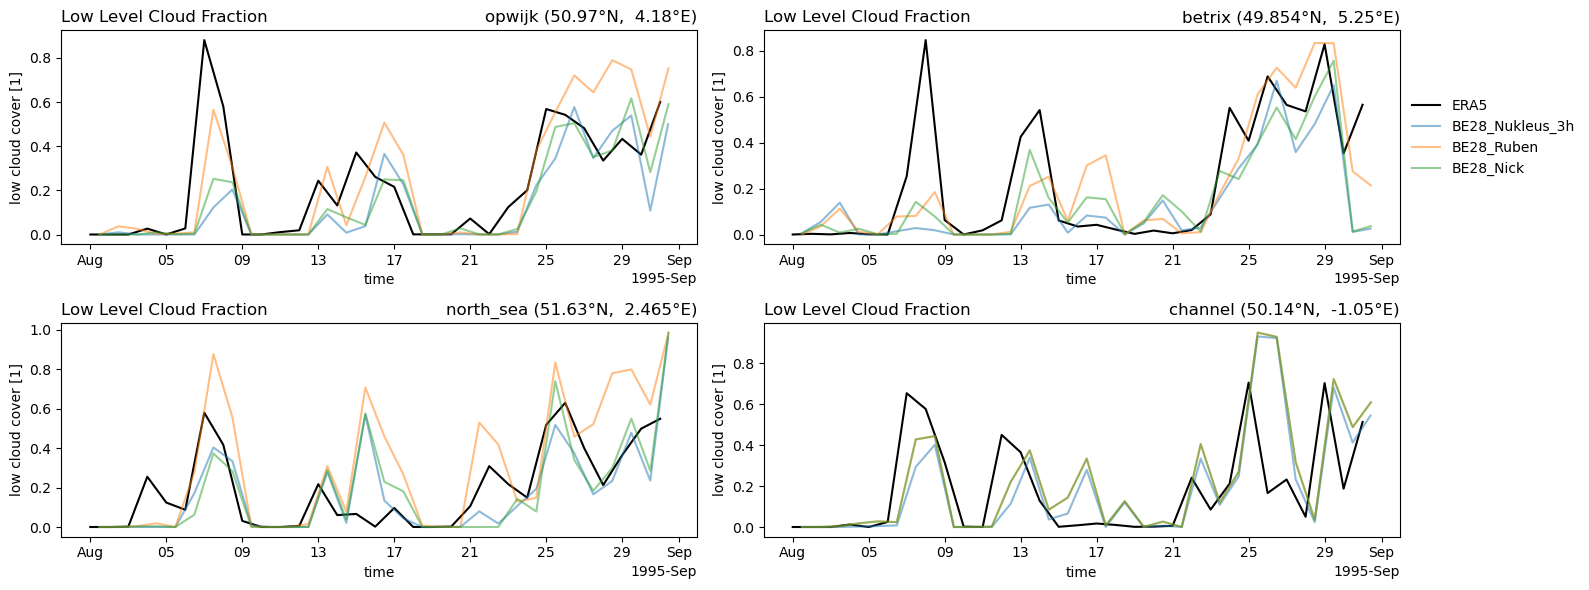

In [19]:
# variables of interest

variable = "cll"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[8])

### medium level clouds

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clm']
The following attributes are missing or incorrect for the variable clm:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clm']
The following attributes are missing or incorrect for the variable clm:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clm']
The following attributes are missing or incorr

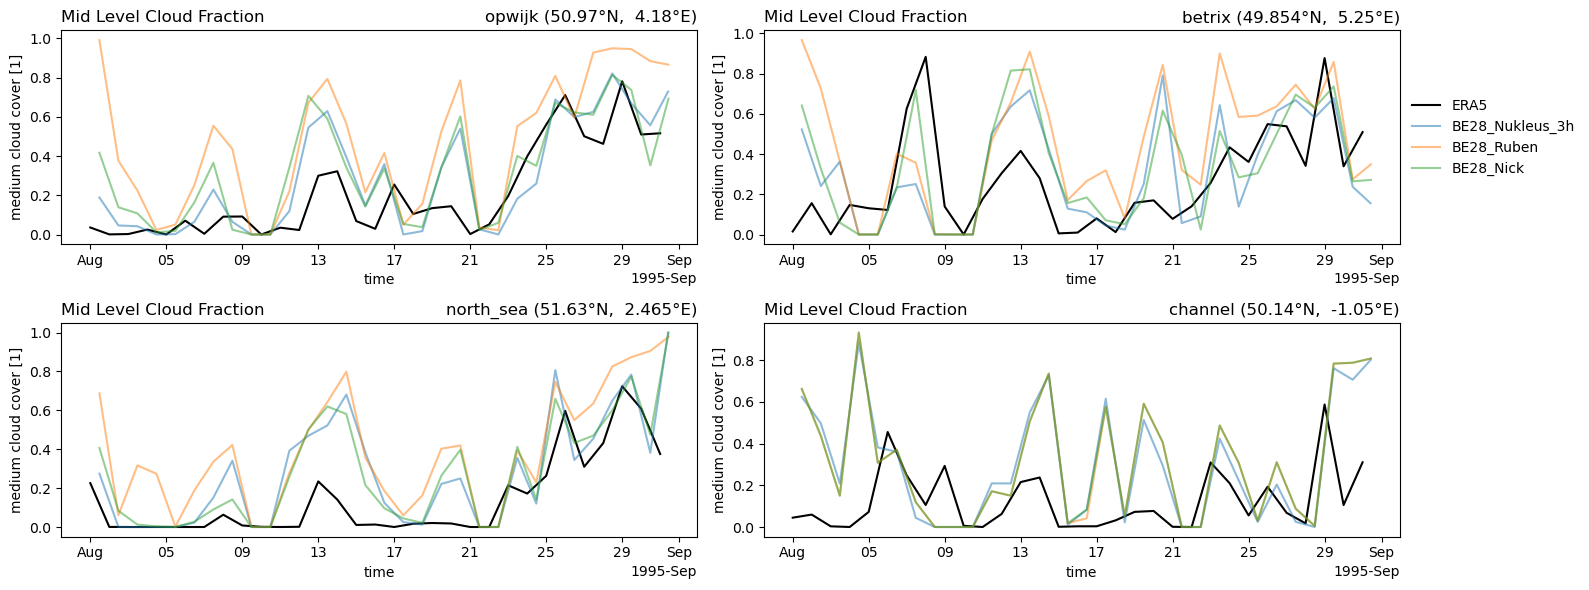

In [20]:
# variables of interest

variable = "clm"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[8])

### high level clouds

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/high_cloud_cover/era5-hourly-europe-high_cloud_cover-1995.nc


Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clh']
The following attributes are missing or incorrect for the variable clh:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/high_cloud_cover/era5-hourly-europe-high_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clh']
The following attributes are missing or incorrect for the variable clh:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           

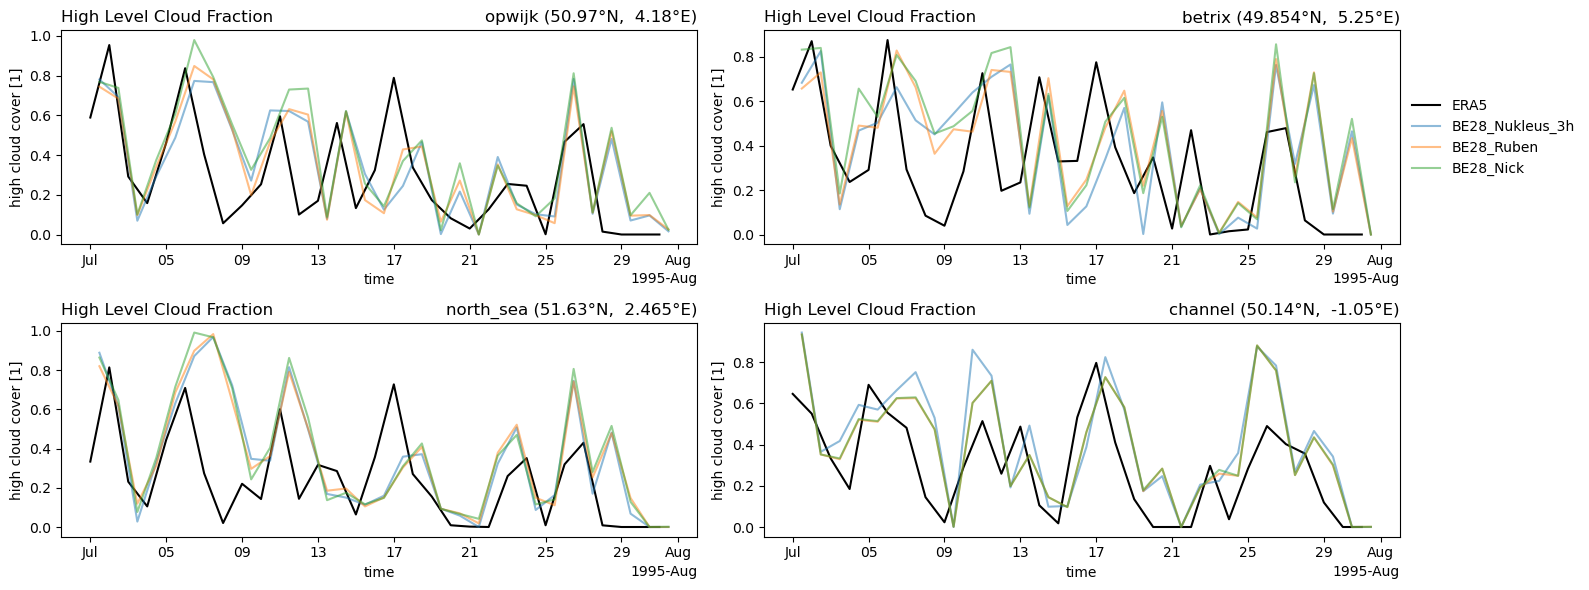

In [21]:
# variables of interest

variable = "clh"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[7])

### Sea level pressure

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/mean_sea_level_pressure/era5-hourly-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/mean_sea_level_pressure/era5-hourly-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/mean_sea_level_pressure/era5-hourly-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/mean_sea_level_pressure/era5-hourly-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']


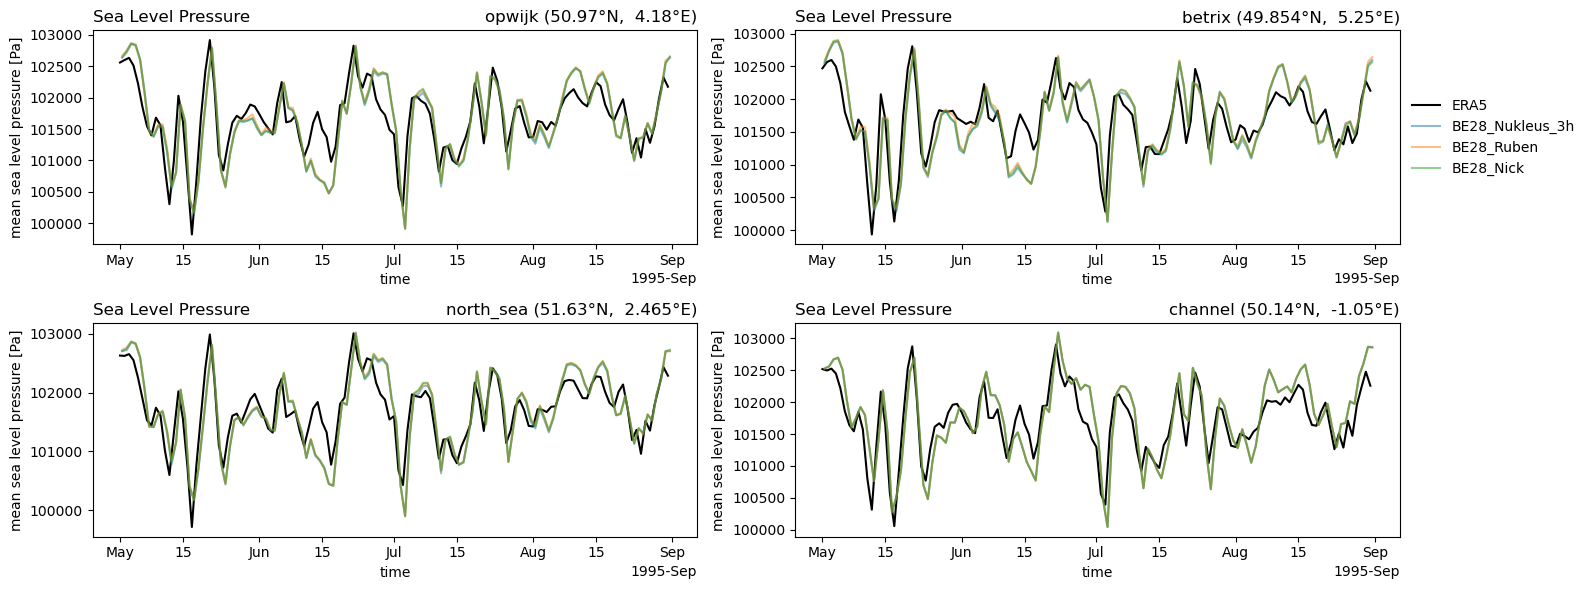

In [22]:
# variables of interest
variable = "psl"
region = 'belgium'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

### Precipitation -- units are not yet correct!!!


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr']
did unit conversion


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr']
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr']
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr']
did unit conversion


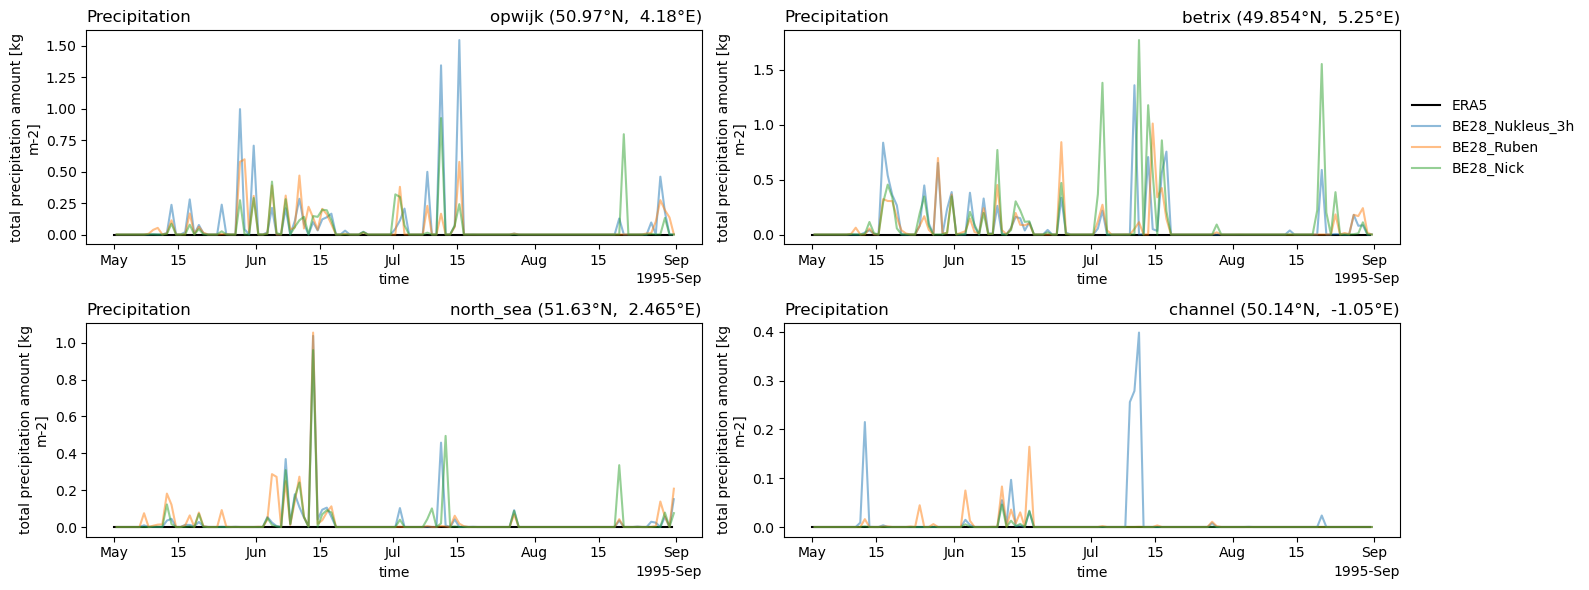

In [23]:
# variables of interest
variable = "pr"
region = 'europe'
ref_dataset = "ERA5"
unit_conversion = "pr"
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion)

### Latent heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfls']
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfls']
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfls']
did unit conversio

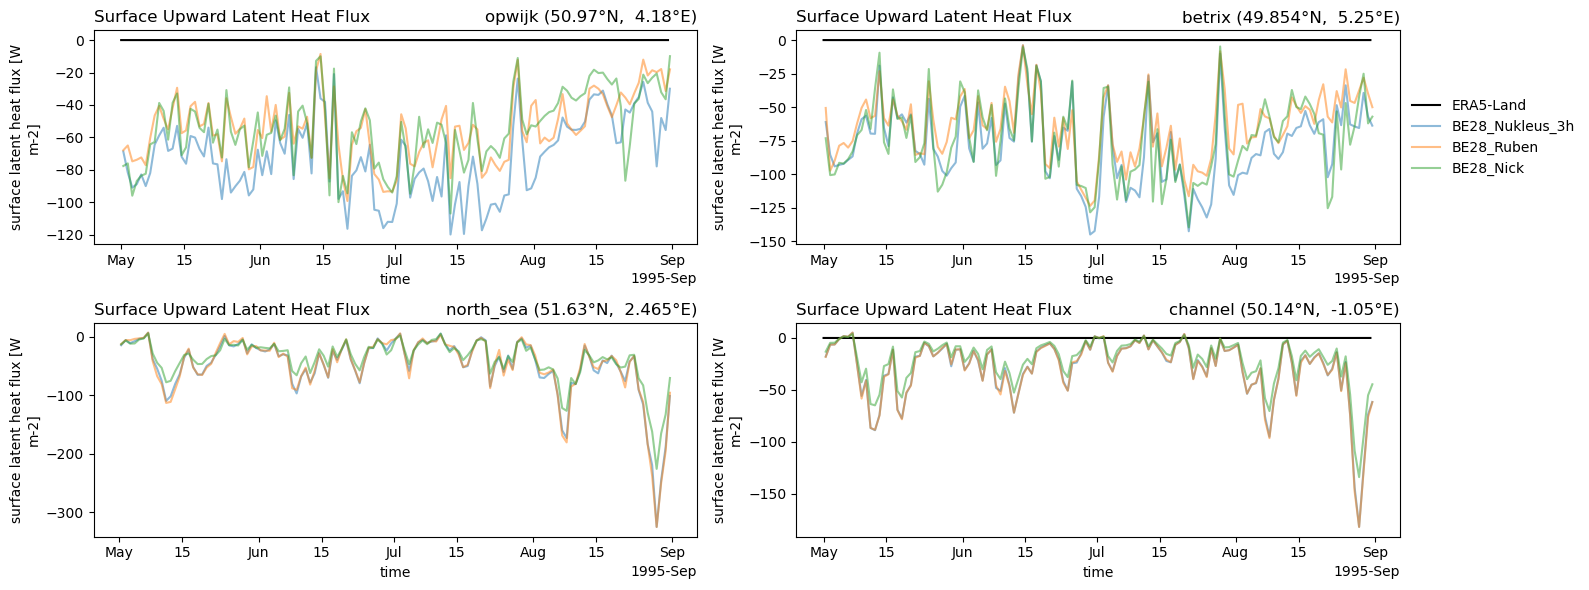

In [24]:
# variables of interest
variable = "hfls"
region = 'belgium'
ref_dataset = 'ERA5-Land'
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=True)

### Sensible heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfss']
did unit conversion


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfss']
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfss']
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfss']
did un

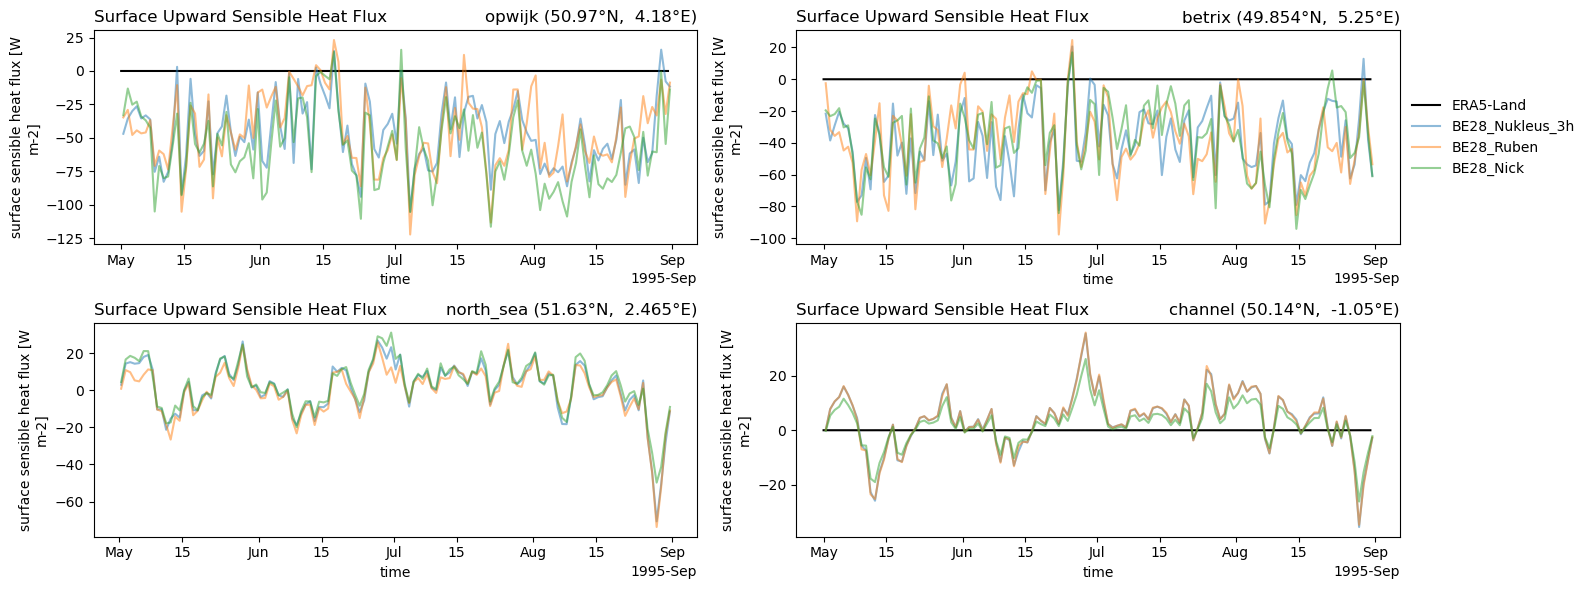

In [25]:
# variables of interest
variable = "hfss"
region = 'belgium'
ref_dataset = 'ERA5-Land'
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=True)

### Surface temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
ts not available for BE28_Nukleus_3h
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
ts not available for BE28_Nukleus_3h
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
ts not available for BE28_Nukleus_3h
F

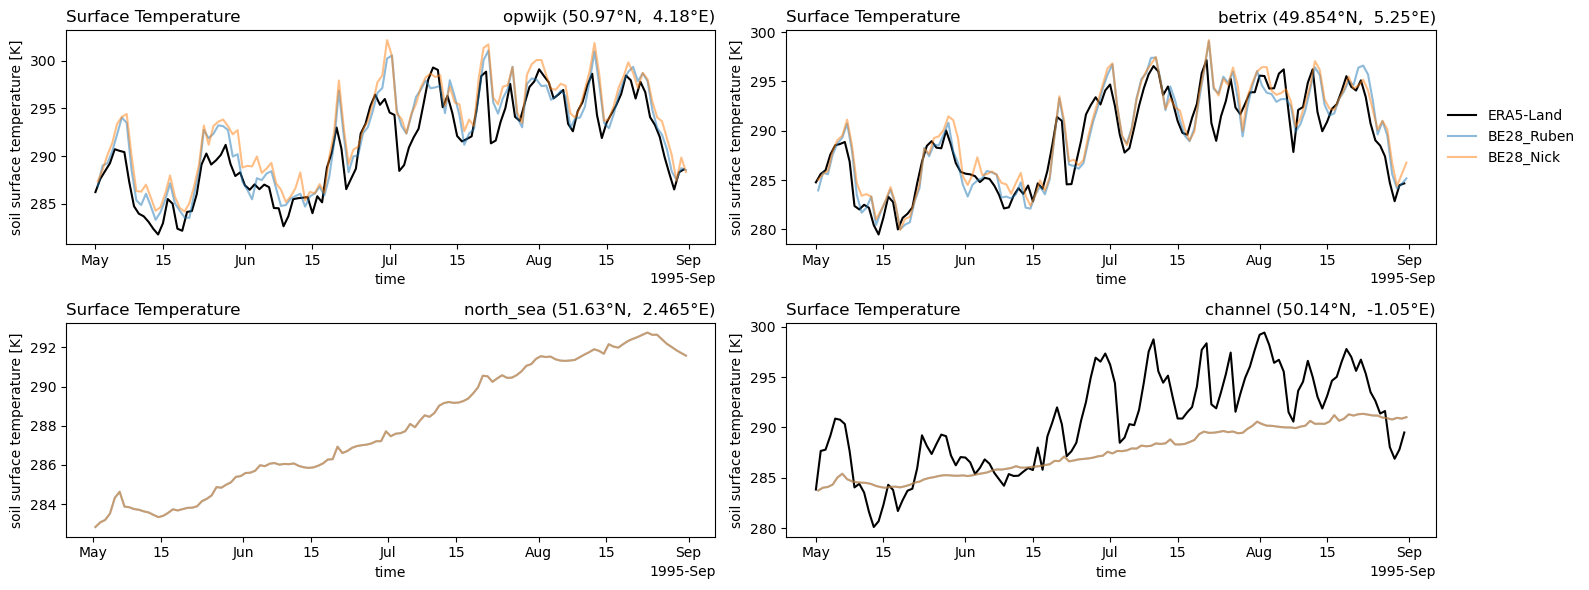

In [26]:
# variables of interest
variable = "ts"
region = 'belgium'
ref_dataset = 'ERA5-Land'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

In [27]:
# start up input manager
manager = vp.InputManager(machine=machine)

# use input manager to load data, defined on settings above
#ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region=region)
ds_obs = ds_obs.resample(time='1D').mean() 

# quick and dirty fix to account for correct units for cumulative variables in ERA5 and ERA5 land - to be properly solved in the inputmanager
if unit_conversion: 
    print('did unit conversion')
    ds_obs[variable] = ds_obs[variable]/(86400)

# select point 
ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


# generate path of CCLM output

# dictorionary to save data arrays of experiments
d_da_mod_point = {}

for experiment in experiments: 
    # get CCLM variable corresponding to the requested variable using its look-up table
    mod_var = mod_LOOKUP[variable]['raw_name']

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

    # open the CCLM file for the corresponding variable
    mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    if not mod_files:  # empty list - move to next element in loop
        print(f"{variable} not available for {experiment}")
        continue
        
    ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

    coord_points_rotated = geo_to_rot(point_coord, ds_mod)
    ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

    da_mod_point = ds_mod_point[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

    d_da_mod_point[experiment] = da_mod_point



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
did unit conversion
ts not available for BE28_Nukleus_3h
ts not available for BE28_Ruben
ts not available for BE28_Nick


In [28]:
da_obs_point.mean('time').values

array(0.003368)

In [29]:
d_da_mod_point[experiment].mean('time').values

KeyError: 'BE28_Nick'

## Points location on a map

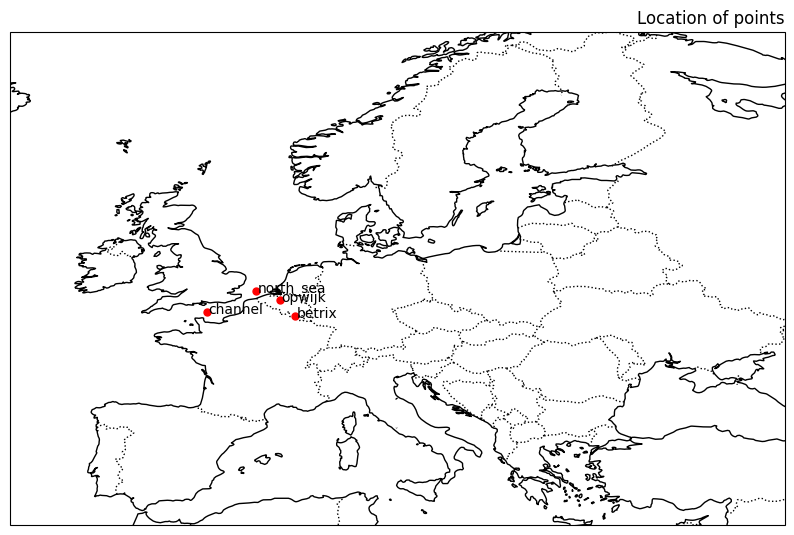

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'europe'

def plot_points_map(d_coord_points: dict, region: str, bounds: str): 

    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot each point and add a label
    for key, (lon, lat) in d_coord_points.items():
        ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat - 0.1, key, transform=ccrs.PlateCarree())

    # Set extent if needed (optional)
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    ax.set_title('Location of points', loc='right')
    # Show the plot
    plt.show()
    fig.savefig("./plots/points_map.png")


plot_points_map(d_coord_points, region, bounds)